# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions

import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.executing_eagerly())

2.4.0
True


## Функции загрузки данных

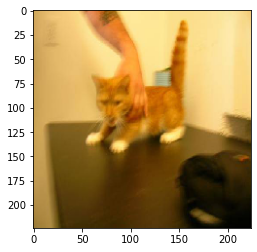

In [2]:
img = image.load_img('data/train/cat.0.jpg', target_size = (224, 224))
plt.imshow(img)
# img = image.img_to_array(img)
# img = np.expand_dims(img, axis=0)
# img = preprocess_input(img)

('n02123045', 'tabby', 0.7103859)


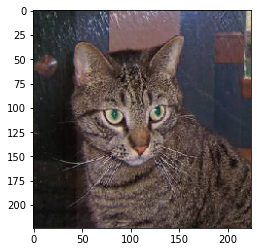

In [3]:
model=ResNet50(weights='imagenet')

img=image.load_img('data/train/cat.1.jpg',target_size=(224,224))

x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=preprocess_input(x)

res=model.predict(x)

print(decode_predictions(res,top=5)[0][0])

plt.imshow(img)

In [4]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train/*.jpg')
test_files = glob('data/test/*.jpg')

# # загружаем входное изображение и предобрабатываем
# def load_image(path, target_size=IMG_SIZE):
#     img = cv2.imread(path)[...,::-1]
#     img = cv2.resize(img, target_size)
#     return vgg16.preprocess_input(img)  # предобработка для VGG16

# # функция-генератор загрузки обучающих данных с диска
# def fit_generator(files, batch_size=32):
#     batch_size = min(batch_size, len(files))
#     while True:
#         shuffle(files)
#         for k in range(len(files) // batch_size):
#             i = k * batch_size
#             j = i + batch_size
#             if j > len(files):
#                 j = - j % len(files)
#             x = np.array([load_image(path) for path in files[i:j]])
#             y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
#                           for path in files[i:j]])
#             yield (x, y)

# # функция-генератор загрузки тестовых изображений с диска
# def predict_generator(files):
#     while True:
#         for path in files:
#             yield np.array([load_image(path)])

In [38]:
# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    
    img=image.load_img(path,target_size=target_size)
   
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
   
    return preprocess_input(img)  # предобработка для ResNet

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path)[0] for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)[0]])

In [26]:
np.array([load_image(path) for path in train_files[1:20]]).shape

(19, 1, 224, 224, 3)

In [27]:
load_image('data/train/cat.1.jpg').shape

(1, 224, 224, 3)

In [28]:
load_image('data/train/cat.1.jpg')[0].shape

(224, 224, 3)

## Визуализируем примеры для обучения

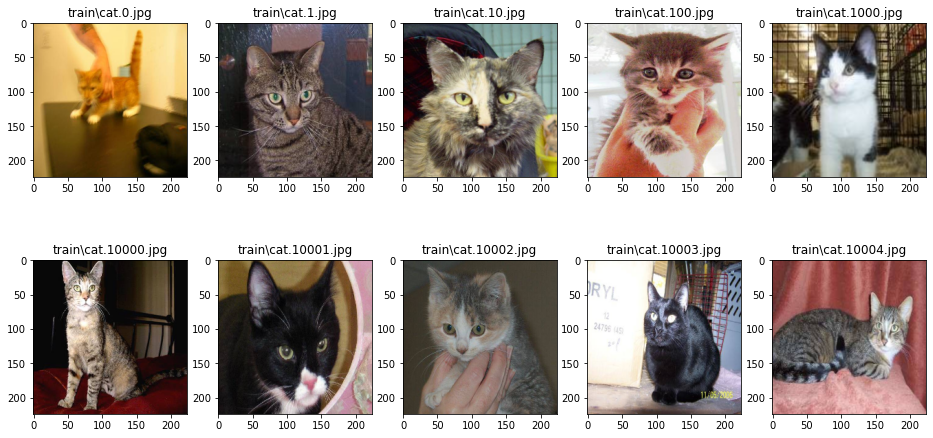

In [10]:
%matplotlib inline

fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [49]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [50]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Добавляем полносвязный слой

In [51]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [52]:
model.summary()

Model: "dogs_vs_cats"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

## Компилируем модель и запускаем обучение

In [53]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [16]:
# Х может уводить сигмоиду в насыщение. Можно успольновать нормировку. Использовать батч норм.

In [54]:
val_samples = 500  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 75s 8s/step - loss: 0.4296 - accuracy: 0.7929 - val_loss: 0.2126 - val_accuracy: 0.9360
Epoch 2/100
10/10 [==============================] - 72s 8s/step - loss: 0.1486 - accuracy: 0.9672 - val_loss: 0.1231 - val_accuracy: 0.9720
Epoch 3/100
10/10 [==============================] - 73s 8s/step - loss: 0.1295 - accuracy: 0.9660 - val_loss: 0.1043 - val_accuracy: 0.9760
Epoch 4/100
10/10 [==============================] - 73s 8s/step - loss: 0.0802 - accuracy: 0.9762 - val_loss: 0.0950 - val_accuracy: 0.9740
Epoch 5/100
10/10 [==============================] - 73s 8s/step - loss: 0.0833 - accuracy: 0.9774 - val_loss: 0.1058 - val_accuracy: 0.9720
Epoch 6/100
10/10 [==============================] - 73s 8s/step - loss: 0.1036 - accuracy: 0.9777 - val_loss: 0.1169 - val_accuracy: 0.9720
Epoch 7/100
10/10 [==============================] - 73s 8s/step - loss: 0.2255 - accuracy: 0.9572 - val_loss: 0.1021 - val_accuracy: 0.9760
Epoch 8/100
1

Epoch 59/100
10/10 [==============================] - 73s 8s/step - loss: 0.2755 - accuracy: 0.9730 - val_loss: 0.1283 - val_accuracy: 0.9740
Epoch 60/100
10/10 [==============================] - 73s 8s/step - loss: 0.0997 - accuracy: 0.9877 - val_loss: 0.1344 - val_accuracy: 0.9800
Epoch 61/100
10/10 [==============================] - 74s 8s/step - loss: 0.3039 - accuracy: 0.9631 - val_loss: 0.1344 - val_accuracy: 0.9800
Epoch 62/100
10/10 [==============================] - 73s 8s/step - loss: 0.2040 - accuracy: 0.9623 - val_loss: 0.1391 - val_accuracy: 0.9820
Epoch 63/100
10/10 [==============================] - 73s 8s/step - loss: 0.3483 - accuracy: 0.9587 - val_loss: 0.1219 - val_accuracy: 0.9860
Epoch 64/100
10/10 [==============================] - 73s 8s/step - loss: 0.1526 - accuracy: 0.9717 - val_loss: 0.1273 - val_accuracy: 0.9760
Epoch 65/100
10/10 [==============================] - 73s 8s/step - loss: 0.3662 - accuracy: 0.9662 - val_loss: 0.1140 - val_accuracy: 0.9760
Epoch 

In [55]:
model.save('cats-dogs-ResNet50.hdf5')

## Предсказания на проверочной выборке

In [56]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

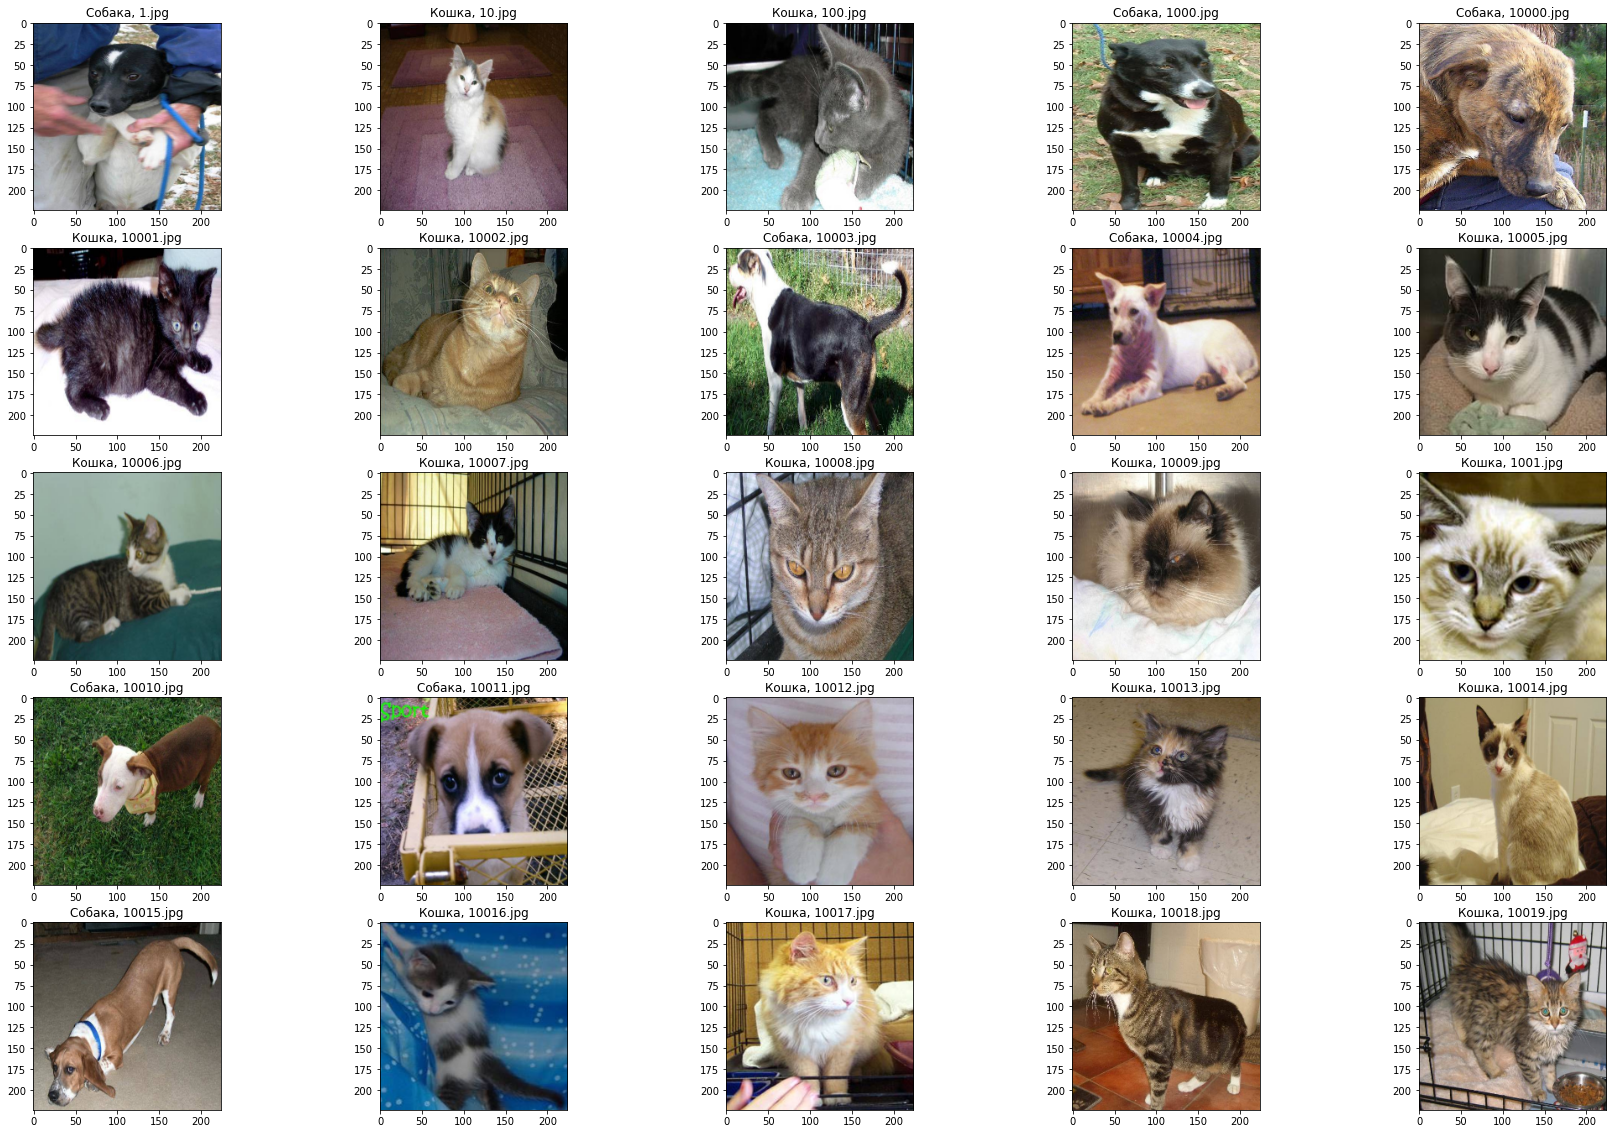

In [62]:
fig = plt.figure(figsize=(30, 20))
for i, (path, score) in enumerate(zip(test_files[:25], test_pred[:25]), 1):
    subplot = fig.add_subplot(5, 5, i)
    if score > 0.5:
        sub = 'Собака'
    else:
        sub = 'Кошка'
    subplot.set_title(f'{sub}, {os.path.basename(path)}')
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [63]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
# LogLoss = 0.27328